In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_statusData(slotData, title):
    x = np.arange(len(slotData))

    mask1 = slotData == 1
    mask2 = slotData == 2
    mask3 = slotData == 3
    mask4 = slotData == 4

    plt.figure(figsize=(16,4))
    plt.bar(x[mask1], slotData[mask1], color = 'blue')
    plt.bar(x[mask2], slotData[mask2], color = 'green')
    plt.bar(x[mask3], slotData[mask3], color = 'orange')
    plt.bar(x[mask4], slotData[mask4], color = 'red')
    plt.title(title)
    plt.xlabel("slot number")
    plt.ylabel("slot status")
    plt.grid()
    plt.show()
    

def plot_outcome(SUCdata, COLdata, BSdata):
    numNodes = SUCdata[:,0]
    transmissions = SUCdata[:,1] + COLdata[:,1] + BSdata[:,1]

    plt.figure(figsize=(10,4))
    plt.plot(numNodes, np.divide(BSdata[:,1], transmissions), label='Below Sensitivity')
    plt.plot(numNodes, np.divide(COLdata[:,1], transmissions), label='Collided')
    plt.plot(numNodes, np.divide(SUCdata[:,1], transmissions), label='Successful')
    plt.title("Transmissions outcome at gateway")
    plt.xlabel('numNodes')
    plt.ylabel('percentage')
    plt.legend()
    plt.grid()


def get_collision_success(slotStatusData):
    idle=0
    success=0
    collision=0
    for i in slotStatusData:
        if i==0 or i==1:
            idle+=1
        if i==2:
            success+=1
        elif i==3 or i==4:
            collision+=1
            
    return (idle, collision, success)


def get_successful_receptions(slotStatusData):
    succ=0
    for i in slotStatusData:
        if i==2 or i==3:
            succ+=1
    return succ

def get_run(run_string):
    par1 = run_string.find('-')
    run_string = run_string[par1+1:]
    par2 = run_string.find('-')
    return int(run_string[:par2])

def get_numNodes(run, nruns, start, step):
    return start + (run // nruns) * step

def get_index(nNodes, start, step):
    return (nNodes - start) // step

def str2vec(data):
    return np.array([float(i.strip()) for i in data.split(" ")])

def vec2str(data):
    s = ""
    for i in data:
        s += str(i)+' '
    return s[:-2]


# start: start numNnodes
# step: step numNnodes
# nruns: repetitions per numNnodes
# returns OCI data 
def get_OCIdata(file, start, step, nruns):
    data = pd.read_csv(file)
    slotStatus = data.loc[(data['name']=='ClassS_Slot_Status')]
    OCIdata = np.zeros((slotStatus.shape[0]//nruns, nruns, 4))

    for i in range(slotStatus.shape[0]):
        run = get_run(slotStatus.iloc[i,0])
        numNodes = get_numNodes(run, nruns, start, step)
        slotData = str2vec(slotStatus.iloc[i,7])
        numNodesId = get_index(numNodes, start, step)
        runId = run % nruns

        i,c,s = get_collision_success(slotData)
        OCIdata[numNodesId][runId][0] = numNodes
        OCIdata[numNodesId][runId][1] = i
        OCIdata[numNodesId][runId][2] = c
        OCIdata[numNodesId][runId][3] = s

    return OCIdata


def get_OCIpolynome(OCIdata, plotNaive):
    numNodes = OCIdata[:,0]
    naive = [(s+2*c) for _,_,c,s in OCIdata]

    p1 = np.polyfit(numNodes, naive, 7)
    naive_smooth = np.polyval(p1, numNodes)
    p2 = np.polyfit(naive_smooth, numNodes, 4)

    if plotNaive:
        # plot results
        plt.figure(figsize=(6,6))
        plt.plot(numNodes, numNodes, label='real value')
        plt.plot(numNodes, naive, label='naive estimation')
        plt.plot(numNodes, naive_smooth, label='naive smooth')
        plt.title("naive estimation")
        plt.xlabel('nodes')
        plt.ylabel("estimation")
        plt.legend()
        plt.grid()
        
    return p2


def get_OCIestimation(testOCIdata, OCIpolynom, title):
    numNodes = testOCIdata[:,0]
    estimationsNaive = [(s+2*c) for _,_,c,s in testOCIdata]
    estimationsOCI = [np.polyval(OCIpolynom, n) for n in estimationsNaive]

    plt.plot(numNodes, numNodes, label="real value")
    plt.plot(numNodes, estimationsNaive, label="naive estimation")
    plt.plot(numNodes, estimationsOCI, label="OCI estimation")
    plt.title(title)
    plt.xlabel('nodes')
    plt.ylabel("estimation")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"OCI estimation RSME = {get_rsme(np.array(numNodes), np.array(estimationsOCI))}")
    print(f"Naive estimation RSME = {get_rsme(np.array(numNodes), np.array(estimationsNaive))}")


def get_BSdata(file, start, step, nruns):
    data = pd.read_csv(file)
    belowSensitivitydata = data.loc[(data['name']=='rcvBelowSensitivity') &
                                (data['module']=='TestNetwork.loRaGW[0].LoRaGWNic.radio.receiver')]

    BSvalues = np.zeros((belowSensitivitydata.shape[0]//nruns, 2))
    for i in range(belowSensitivitydata.shape[0]):
        run = get_run(belowSensitivitydata.iloc[i,0])
        numNodes = get_numNodes(run, nruns, start, step)
        id = get_index(numNodes, start, step)
        
        BScount = int(belowSensitivitydata.iloc[i,6])
        BSvalues[id][0] += numNodes
        BSvalues[id][1] += BScount#/numNodes
        
    BSvalues /= nruns
    return BSvalues


def get_COLdata(file, start, step, nruns):
    data = pd.read_csv(file)
    collisiondata = data.loc[(data['name']=='numCollisions') &
                                (data['module']=='TestNetwork.loRaGW[0].LoRaGWNic.radio.receiver')]

    COLvalues = np.zeros((collisiondata.shape[0]//nruns, 2))
    for i in range(collisiondata.shape[0]):
        run = get_run(collisiondata.iloc[i,0])
        numNodes = get_numNodes(run, nruns, start, step)
        id = get_index(numNodes, start, step)

        COLcount = int(collisiondata.iloc[i,6])
        COLvalues[id][0] += numNodes
        COLvalues[id][1] += COLcount#/numNodes
        
    COLvalues /= nruns
    return COLvalues


def get_SUCdata(file, start, step, nruns):
    data = pd.read_csv(file)
    successfulData = data.loc[(data['name']=='rcvdFromLoRa') &
                                (data['module']=='TestNetwork.loRaGW[0].packetHandler')]

    SUCvalues = np.zeros((successfulData.shape[0]//nruns, 2))
    for i in range(successfulData.shape[0]):
        run = get_run(successfulData.iloc[i,0])
        numNodes = get_numNodes(run, nruns, start, step)
        id = get_index(numNodes, start, step)
        
        SUCcount = int(successfulData.iloc[i,6])
        SUCvalues[id][0] += numNodes
        SUCvalues[id][1] += SUCcount#/numNodes
        
    SUCvalues /= nruns
    return SUCvalues


# assuming all nodes receive the beacon, the throughput is
# throughput = numNodes - numCollision - numBelowSensitivity
def get_successful(COLvalues, BSvalues):
    successful=[]
    for nodes, col, bs in zip(COLvalues[:,0], COLvalues[:,1], BSvalues[:,1]):
        successful.append([nodes, 1-col-bs])
        
    return np.array(successful)


def get_throughput(SUCvalues, COLvalues, BSvalues):
    throughput=[]
    for nodes, suc, col, bs in zip(COLvalues[:,0], SUCvalues[:,1], COLvalues[:,1], BSvalues[:,1]):
        throughput.append([nodes, suc/(suc+col+bs)])
        
    return np.array(throughput)


# RSME root mean squared error
# assuming vector are numpy arrays of the same length
def get_rsme(numNodes, OCIestimation):
    return np.linalg.norm(numNodes - OCIestimation) / np.sqrt(len(numNodes))


def get_rsme_data(OCItrainData, testOCIdata):
    rsmeValues=[]
    testNodeValues=[]

    # should be the same as testOCIdata.shape[0]
    samples = OCItrainData.shape[0]

    for i in range(8, samples+1):
        p2 = get_OCIpolynome(OCItrainData[:i,:], False)
        testOCIdataMeansub = testOCIdata[:i,:]

        #print(f"train nodes: {OCItrainData[i-1][0]}")
        #print(f"train nodes: {testOCIdata[i-1][0]}\n")

        numNodes = testOCIdataMeansub[:,0]
        estimationsNaive = [(s+2*c) for _,_,c,s in testOCIdataMeansub]
        estimationsOCI = [np.polyval(p2, n) for n in estimationsNaive]

        testNodeValues.append(numNodes[-1])
        rsmeValues.append(get_rsme(np.array(numNodes), np.array(estimationsOCI)))

    return testNodeValues, rsmeValues


def plot_rsme(nodes, rsme, slots, lim1, lim2, color):
    id1 = nodes.index(lim1)
    id2 = nodes.index(lim2)
    plt.plot(nodes, rsme, label=f'nSlots={slots}', color=color, linewidth=1)
    plt.scatter(nodes[id1], rsme[id1], color=color, marker='o')
    plt.scatter(nodes[id2], rsme[id2], color=color, marker='v')


def plot_rsme2(nodes, rsme, slots, lim1, color):
    id1 = nodes.index(lim1)
    plt.plot(nodes, rsme, label=f'nSlots={slots}', color=color, linewidth=1)
    plt.scatter(nodes[id1], rsme[id1], color=color, marker='o')

for suc, col, bs in zip(SUCdata, COLdata, BSdata):
    x=suc+col+bs
    print(f"nodes= {x[0]/3};    suc= {round(suc[1],1)};    bs= {round(bs[1],1)};    col= {round(col[1],1)};    tx= {round(x[1],1)}")

---
# OCI estimation SF10 BW125 BCN91 nSlots=167



## train data SF9 BW125
---
### OCI test with game

C:\Users\diego\AppData\Local\Temp\ipykernel_16876\2120498217.py:85: DtypeWarning: Columns (2,3,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file)
C:\Users\diego\AppData\Local\Temp\ipykernel_16876\2120498217.py:148: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file)
C:\Users\diego\AppData\Local\Temp\ipykernel_16876\2120498217.py:167: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file)
C:\Users\diego\AppData\Local\Temp\ipykernel_16876\2120498217.py:186: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file)


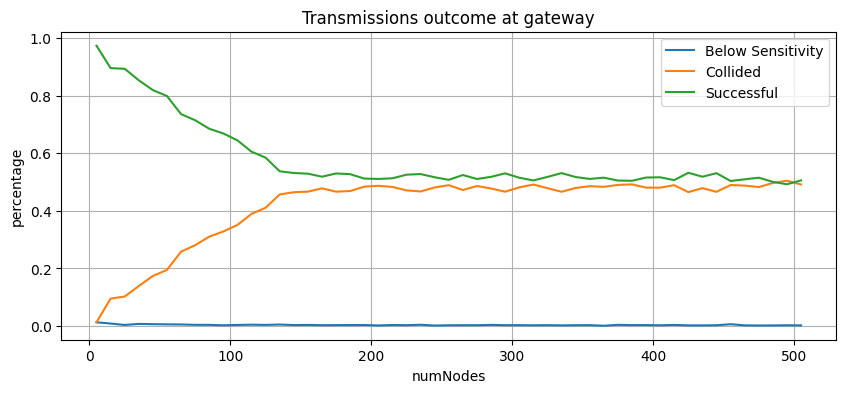

In [3]:
SF=10
BW=125
BCN=91

start = 5
end = 505
step = 10
nruns = 30
testdata = f"{start}to{end}step{step}"
basefilestr = '_'.join([f'SF{SF}', f'BW{BW}', f'BCN{BCN}', testdata, f'runs{nruns}'])

testOCIdata = get_OCIdata(basefilestr + "_slotdata_game.csv", start, step, nruns)
BSdata = get_BSdata(basefilestr + "_lowpower_game.csv", start, step, nruns)
COLdata = get_COLdata(basefilestr + "_collisions_game.csv", start, step, nruns)
SUCdata = get_SUCdata(basefilestr + "_successful_game.csv", start, step, nruns)

plot_outcome(SUCdata, COLdata, BSdata)

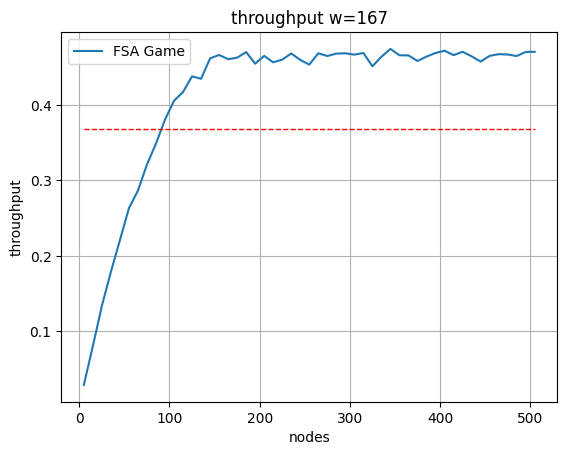

In [4]:
nSlots = 167
plt.plot(SUCdata[:,0], SUCdata[:,1]/nSlots, label='FSA Game')
plt.plot(SUCdata[:,0], [.368]*len(SUCdata[:,0]), linewidth=1, linestyle='dashed', color='r')
plt.title(f"throughput w={nSlots}")
plt.xlabel('nodes')
plt.ylabel("throughput")
plt.legend()
plt.grid()
plt.show()

---
## train data SF10 BW125

---
## OCI test with game

C:\Users\diego\AppData\Local\Temp\ipykernel_16876\2120498217.py:85: DtypeWarning: Columns (2,3,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file)
C:\Users\diego\AppData\Local\Temp\ipykernel_16876\2120498217.py:148: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file)
C:\Users\diego\AppData\Local\Temp\ipykernel_16876\2120498217.py:167: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file)
C:\Users\diego\AppData\Local\Temp\ipykernel_16876\2120498217.py:186: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file)


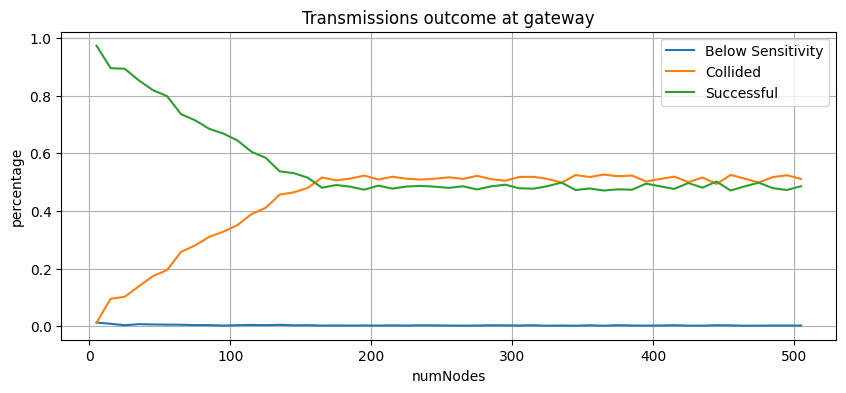

In [5]:
testOCIdata = get_OCIdata(basefilestr + "_slotdata_game2.csv", start, step, nruns)
BSdata = get_BSdata(basefilestr + "_lowpower_game2.csv", start, step, nruns)
COLdata = get_COLdata(basefilestr + "_collisions_game2.csv", start, step, nruns)
SUCdata2 = get_SUCdata(basefilestr + "_successful_game2.csv", start, step, nruns)

plot_outcome(SUCdata2, COLdata, BSdata)

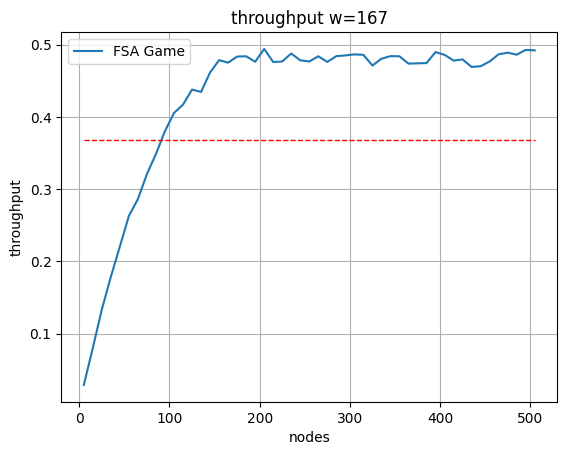

In [6]:
nSlots = 167
plt.plot(SUCdata2[:,0], SUCdata2[:,1]/nSlots, label='FSA Game')
plt.plot(SUCdata2[:,0], [.368]*len(SUCdata2[:,0]), linewidth=1, linestyle='dashed', color='r')
plt.title(f"throughput w={nSlots}")
plt.xlabel('nodes')
plt.ylabel("throughput")
plt.legend()
plt.grid()
plt.show()

---
## train data SF12 BW125
---
### OCI test with game

C:\Users\diego\AppData\Local\Temp\ipykernel_16876\2120498217.py:85: DtypeWarning: Columns (2,3,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file)
C:\Users\diego\AppData\Local\Temp\ipykernel_16876\2120498217.py:148: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file)
C:\Users\diego\AppData\Local\Temp\ipykernel_16876\2120498217.py:167: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file)
C:\Users\diego\AppData\Local\Temp\ipykernel_16876\2120498217.py:186: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file)


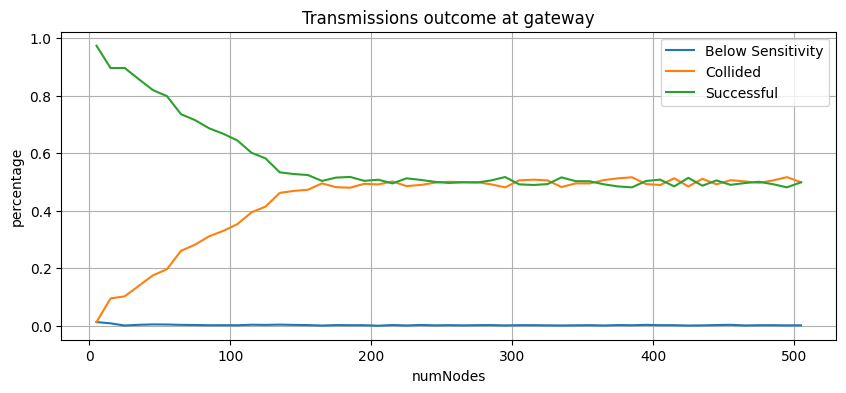

In [7]:
testOCIdata = get_OCIdata(basefilestr + "_slotdata_game3.csv", start, step, nruns)
BSdata = get_BSdata(basefilestr + "_lowpower_game3.csv", start, step, nruns)
COLdata = get_COLdata(basefilestr + "_collisions_game3.csv", start, step, nruns)
SUCdata3 = get_SUCdata(basefilestr + "_successful_game3.csv", start, step, nruns)

plot_outcome(SUCdata3, COLdata, BSdata)

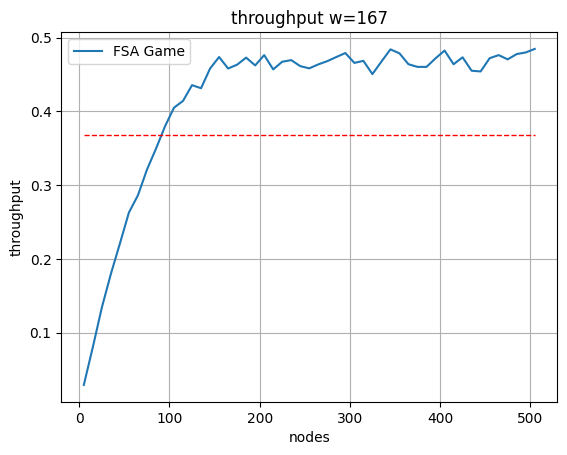

In [8]:
nSlots = 167
plt.plot(SUCdata3[:,0], SUCdata3[:,1]/nSlots, label='FSA Game')
plt.plot(SUCdata3[:,0], [.368]*len(SUCdata3[:,0]), linewidth=1, linestyle='dashed', color='r')
plt.title(f"throughput w={nSlots}")
plt.xlabel('nodes')
plt.ylabel("throughput")
plt.legend()
plt.grid()
plt.show()

---
## OCI test without game

C:\Users\diego\AppData\Local\Temp\ipykernel_16876\2120498217.py:85: DtypeWarning: Columns (2,3,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file)
C:\Users\diego\AppData\Local\Temp\ipykernel_16876\2120498217.py:148: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file)
C:\Users\diego\AppData\Local\Temp\ipykernel_16876\2120498217.py:167: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file)
C:\Users\diego\AppData\Local\Temp\ipykernel_16876\2120498217.py:186: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file)


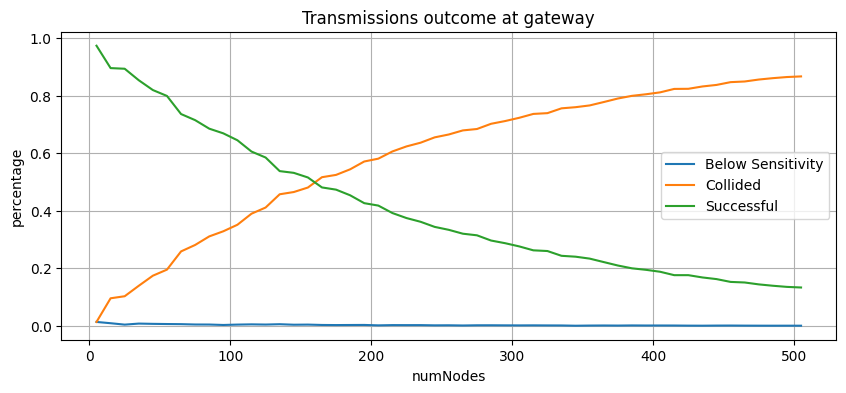

In [9]:
testOCIdata = get_OCIdata(basefilestr + "_slotdata.csv", start, step, nruns)
BSdata = get_BSdata(basefilestr + "_lowpower.csv", start, step, nruns)
COLdata = get_COLdata(basefilestr + "_collisions.csv", start, step, nruns)
pureSUCdata = get_SUCdata(basefilestr + "_successful.csv", start, step, nruns)

plot_outcome(pureSUCdata, COLdata, BSdata)

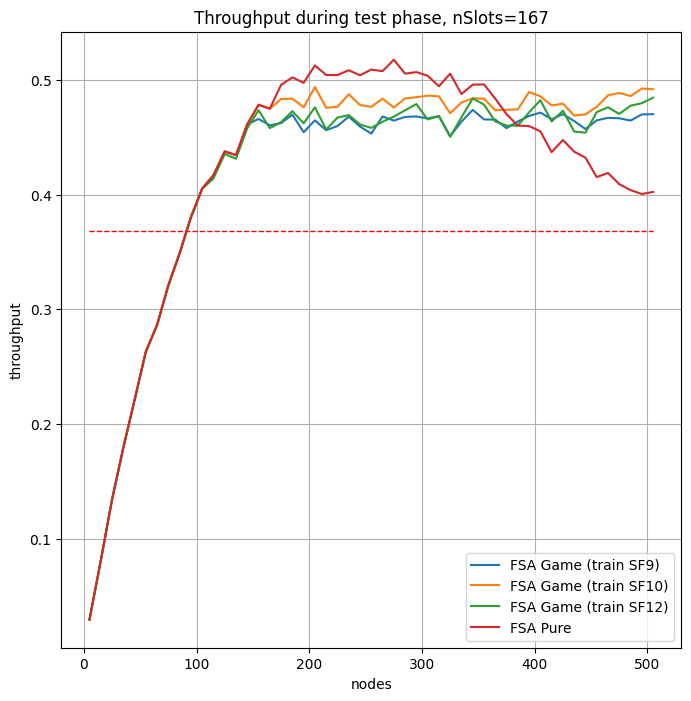

In [10]:
plt.figure(figsize=(8,8))
plt.plot(SUCdata[:,0], SUCdata[:,1]/nSlots, label='FSA Game (train SF9)')
plt.plot(SUCdata2[:,0], SUCdata2[:,1]/nSlots, label='FSA Game (train SF10)')
plt.plot(SUCdata3[:,0], SUCdata3[:,1]/nSlots, label='FSA Game (train SF12)')
plt.plot(pureSUCdata[:,0], pureSUCdata[:,1]/nSlots, label='FSA Pure')
plt.plot(SUCdata[:,0], [.368]*len(SUCdata[:,0]), linewidth=1, linestyle='dashed', color='r')
plt.title(f"Throughput during test phase, nSlots={nSlots}")
plt.xlabel('nodes')
plt.ylabel("throughput")
plt.legend()
plt.grid()
plt.show()

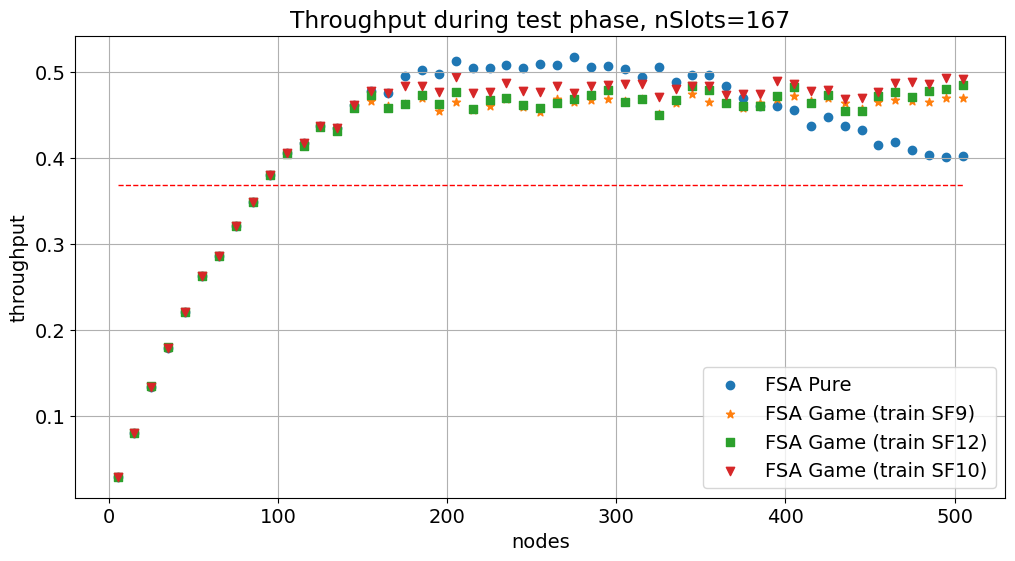

In [18]:
plt.rcParams['font.size'] = 14

plt.figure(figsize=(12,6))
plt.scatter(pureSUCdata[:,0], pureSUCdata[:,1]/nSlots, label='FSA Pure')
plt.scatter(SUCdata[:,0], SUCdata[:,1]/nSlots, marker='*', label='FSA Game (train SF9)')
plt.scatter(SUCdata3[:,0], SUCdata3[:,1]/nSlots, marker='s', label='FSA Game (train SF12)')
plt.scatter(SUCdata2[:,0], SUCdata2[:,1]/nSlots, marker='v', label='FSA Game (train SF10)')
plt.plot(SUCdata[:,0], [.368]*len(SUCdata[:,0]), linewidth=1, linestyle='dashed', color='r')
plt.title(f"Throughput during test phase, nSlots={nSlots}")
plt.xlabel('nodes')
plt.ylabel("throughput")
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [12]:
avgThroughout = np.mean(SUCdata[20:,1]/nSlots)
avgThroughout2 = np.mean(SUCdata2[20:,1]/nSlots)
avgThroughout3 = np.mean(SUCdata3[20:,1]/nSlots)

In [13]:
avgThroughout

0.46482518833301145

In [14]:
avgThroughout2

0.48149507436739425

In [15]:
avgThroughout3

0.4688558367136694